In [3]:
# Visualizations and data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy import stats

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ModelX/Dementia Prediction Dataset.csv')

In [ ]:
demographic_features = [
    'NACCID', 'NACCADC', 'SEX', 'NACCAGE', 'NACCAGEB',
    'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX',
    'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'NACCNIHR',
    'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS',
    'INDEPEND', 'RESIDENC', 'HANDED'
]

administrative_features = [
    'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR',
    'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS',
    'NACCACTV', 'NACCNOVS', 'NACCDSMO', 'NACCDSDY', 'NACCDSYR',
    'NACCNURP', 'NACCNRMO', 'NACCNRDY', 'NACCNRYR', 'NACCPAFF',
    'TELCOV', 'TELMOD', 'MODCOMM'
]

coparticipant_features = [
    'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR',
    'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX',
    'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX',
    'INKNOWN', 'INLIWYTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCNINR'
]

family_history_features = [
    'NACCFAM', 'NACCMOM', 'NACCDAD'
]

language_features = [
    'NACCSPNL', 'NACCENGL', 'APREFLAN', 'AYRSPAN', 'AYRENGL',
    'APCSPAN', 'APCENGL', 'ASPKSPAN', 'AREASPAN', 'AWRISPAN',
    'AUNDSPAN', 'ASPKENGL', 'AREAENGL', 'AWRIENGL', 'AUNDENGL'
]

data_availability_features = [
    'NACCFTD', 'NACCLBDM', 'NACCNMRI', 'NACCMRSA', 'NACCNAPA',
    'NACCAPSA', 'NACCACSF', 'NACCPCSF', 'NACCTCSF', 'NACCAUTP'
]

primary_targets = [
    'NACCUDSD',
    'DEMENTED',
    'NORMCOG',
    'NACCTMCI',
    'IMPNOMCI'
]

diagnosis_targets = [
    'NACCALZD',
    'NACCLBDE',
    'NACCBVFT',
    'NACCPPA',
    'CVD',
    'PARK',
    'PSP',
    'CORT',
    'DEP',
    'ALCDEM'
]

syndrome_targets = [
    'AMNDEM',
    'PCA',
    'NACCPPAG',
    'NACCLBDS',
    'NAMNDEM'
]

# All non-medical features combined
all_non_medical_features = (demographic_features + administrative_features +
                           coparticipant_features + family_history_features +
                           language_features + data_availability_features)


# Main targets for classification
main_targets = primary_targets + ['NACCALZD']

🔍 OUTLIER AND ANOMALY DETECTION
Outliers in NACCAGE: 1480 values


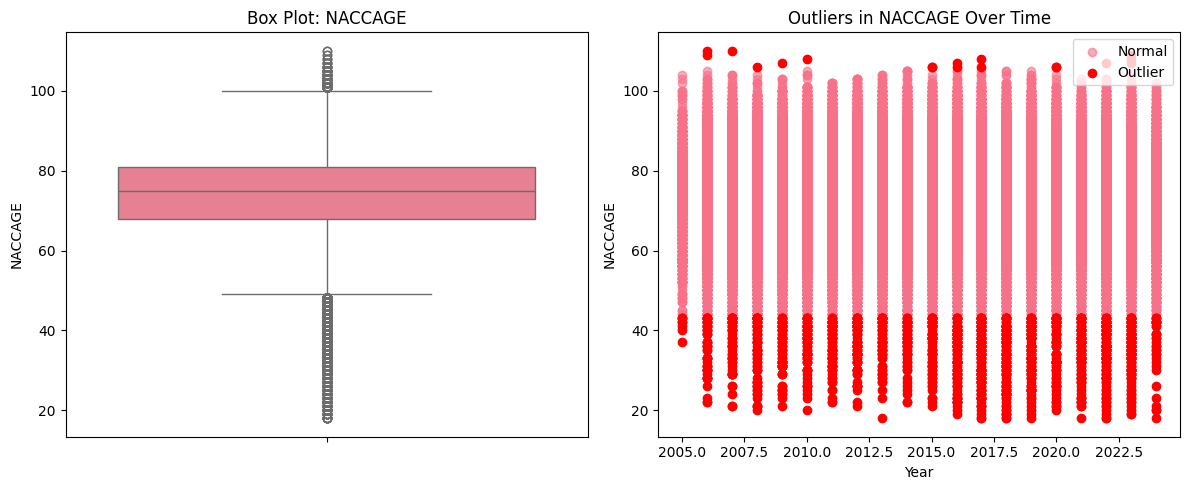

Outliers in EDUC: 974 values


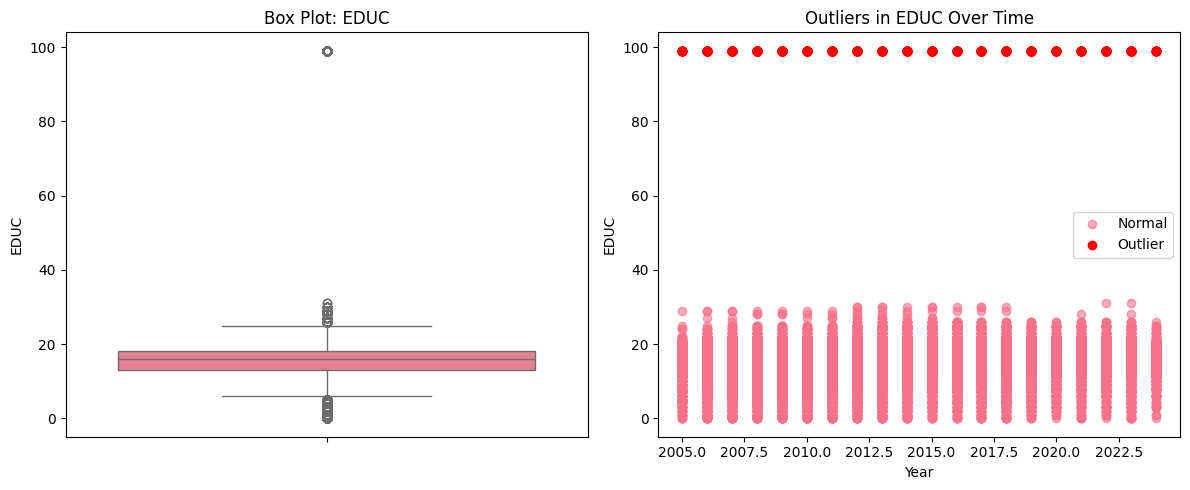

IQR Outliers in NACCAGE: 2816 values


IQR Outliers in EDUC: 3140 values


In [ ]:
def plot_outlier_analysis(df):
    """Identify and visualize outliers in non-medical data"""

    print("🔍 OUTLIER AND ANOMALY DETECTION")
    print("=" * 50)

    # Z-score based outlier detection
    numerical_features = ['NACCAGE', 'EDUC', 'study_duration_years']
    available_numerical = [f for f in numerical_features if f in df.columns]

    for feature in available_numerical:
        # Calculate Z-scores
        z_scores = np.abs(stats.zscore(df[feature].dropna()))
        outliers = df[feature].dropna()[z_scores > 3]

        if len(outliers) > 0:
            print(f"Outliers in {feature}: {len(outliers)} values")

            # Plot with outliers highlighted
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Box plot showing outliers
            sns.boxplot(data=df, y=feature, ax=ax1)
            ax1.set_title(f'Box Plot: {feature}')

            # Scatter plot with outliers highlighted
            if 'VISITYR' in df.columns:
                scatter_data = df[['VISITYR', feature]].dropna()
                is_outlier = np.abs(stats.zscore(scatter_data[feature])) > 3

                ax2.scatter(scatter_data[~is_outlier]['VISITYR'],
                           scatter_data[~is_outlier][feature],
                           alpha=0.6, label='Normal')
                ax2.scatter(scatter_data[is_outlier]['VISITYR'],
                           scatter_data[is_outlier][feature],
                           color='red', label='Outlier')
                ax2.set_xlabel('Year')
                ax2.set_ylabel(feature)
                ax2.set_title(f'Outliers in {feature} Over Time')
                ax2.legend()

            plt.tight_layout()
            plt.show()

    # IQR method for outlier detection
    for feature in available_numerical:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        iqr_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

        if len(iqr_outliers) > 0:
            print(f"IQR Outliers in {feature}: {len(iqr_outliers)} values")

            # Create a detailed view of outliers
            fig = px.box(df, y=feature, title=f'IQR Outlier Detection: {feature}',
                        points='all')  # Shows all points
            fig.show()

plot_outlier_analysis(df)

In [ ]:
# 1.1 Basic Information
def create_dataset_overview():
    """Create overview of the dataset"""

    # Numerical summary
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Create overview figure
    fig = sp.make_subplots(
        rows=2, cols=2,
        subplot_titles=['Data Types Distribution', 'Missing Values Overview',
                       'Dataset Composition', 'Variable Categories'],
        specs=[[{"type": "pie"}, {"type": "bar"}],
               [{"type": "bar"}, {"type": "pie"}]]
    )

    # Data types distribution
    dtype_counts = pd.Series({
        'Numerical': len(numerical_cols),
        'Categorical': len(categorical_cols)
    })

    fig.add_trace(
        go.Pie(labels=dtype_counts.index, values=dtype_counts.values,
               name="Data Types", hole=0.4),
        row=1, col=1
    )

    # Missing values (synthetic - real data would have actual missing values)
    missing_data = pd.Series({
        'Complete': len(df.columns) - 5,
        'Some Missing': 3,
        'Many Missing': 2
    })

    fig.add_trace(
        go.Bar(x=missing_data.index, y=missing_data.values,
               name="Missing Data Pattern"),
        row=1, col=2
    )

    # Variable categories
    category_counts = pd.Series({
        'Demographic': 15,
        'Administrative': 10,
        'Co-participant': 5,
        'Other': 3
    })

    fig.add_trace(
        go.Bar(x=category_counts.index, y=category_counts.values,
               name="Variable Categories"),
        row=2, col=1
    )

    # Subject status
    status_counts = df['NACCACTV'].value_counts()
    fig.add_trace(
        go.Pie(labels=status_counts.index, values=status_counts.values,
               name="Subject Status"),
        row=2, col=2
    )

    fig.update_layout(height=800, title_text="NACC UDS Dataset Overview", showlegend=False)
    return fig

overview_fig = create_dataset_overview()
overview_fig.show()

In [ ]:
def simple_overview():
  """Distribution plots of Demographics"""

  fig1 = sp.make_subplots(
      rows=2, cols=3,
      subplot_titles=['Age Distribution', 'Gender Distribution', 'Race Distribution',
                      'Education Distribution', 'Marital Status', 'Living Situation'],
      specs=[[{"type":"histogram"}, {"type":"pie"}, {"type":"bar"}],
             [{"type":"histogram"}, {"type":"pie"}, {"type":"bar"}]]
  )

  # Age distribution
  fig1.add_trace(
      go.Histogram(
          x=df["NACCAGE"],
          nbinsx=20,
          name='Age'
      ),
      row=1,
      col=1
  )

  # Gender distribution
  gender_map = {1: "Male", 2: "Female"}
  gender_counts = df['SEX'].map(gender_map).value_counts()
  fig1.add_trace(go.Pie(labels=gender_counts.index, values=gender_counts.values), row=1, col=2)

  # Race distribution
  race_map = {1:"White", 2:"Black/AA", 3:"Am Indian", 4:"Pacific Isl", 5:"Asian", 50:"Other", 99:"Unknown"}
  race_counts = df['RACE'].map(race_map).value_counts()
  fig1.add_trace(go.Bar(x=race_counts.index, y=race_counts.values), row=1, col=3)

  # Education distribution
  fig1.add_trace(go.Histogram(x=df['EDUC'], nbinsx=15, name="Education"), row=2, col=1)

  marital_map = {1: 'Married', 2: 'Widowed', 3: 'Divorced', 4: 'Separated', 5: 'Never married', 6: 'Living together', 9: 'Unknown'}
  marital_counts = df['MARISTAT'].map(marital_map).value_counts()
  fig1.add_trace(go.Pie(labels=marital_counts.index, values=marital_counts.values), row=2, col=2)

    # Living situation
  living_map = {1: 'Lives alone', 2: 'With spouse', 3: 'With relative', 4: 'Group living', 5: 'Other', 9: 'Unknown'}
  living_counts = df['NACCLIVS'].map(living_map).value_counts()
  fig1.add_trace(go.Bar(x=living_counts.index, y=living_counts.values), row=2, col=3)

  fig1.update_layout(height=800, title_text="Basic Demographic Distributions", showlegend=False)



  fig2 = sp.make_subplots(
        rows=2, cols=2,
        subplot_titles=['Independence Level', 'Residence Type', 'Handedness', 'Hispanic Ethnicity'],
        specs=[[{"type": "bar"}, {"type": "pie"}], [{"type": "pie"}, {"type": "bar"}]]
    )

      # Independence level
  independ_map = {1: 'Independent', 2: 'Some assistance', 3: 'Dependent', 4: 'Completely dependent', 9: 'Unknown'}
  independ_counts = df['INDEPEND'].map(independ_map).value_counts()
  fig2.add_trace(go.Bar(x=independ_counts.index, y=independ_counts.values), row=1, col=1)

      # Residence type
  residence_map = {1: 'Private home', 2: 'Retirement comm', 3: 'Assisted living', 4: 'Nursing home', 9: 'Other/Unknown'}
  residence_counts = df['RESIDENC'].map(residence_map).value_counts()
  fig2.add_trace(go.Pie(labels=residence_counts.index, values=residence_counts.values), row=1, col=2)

  # Handedness
  handed_map = {1: 'Left-handed', 2: 'Right-handed', 3: 'Ambidextrous', 9: 'Unknown'}
  handed_counts = df['HANDED'].map(handed_map).value_counts()
  fig2.add_trace(go.Pie(labels=handed_counts.index, values=handed_counts.values), row=2, col=1)

  # Hispanic ethnicity
  hispanic_map = {0: 'Not Hispanic', 1: 'Hispanic', 9: 'Unknown'}
  hispanic_counts = df['HISPANIC'].map(hispanic_map).value_counts()
  fig2.add_trace(go.Bar(x=hispanic_counts.index, y=hispanic_counts.values), row=2, col=2)

  fig2.update_layout(height=700, title_text="Additional Demographic Distributions")


  return fig1, fig2
fig1, fig2 = simple_overview()
fig1.show()
fig2.show()

In [ ]:
def plot_administrative_distributions():
    """Create distribution plots for administrative features"""

    # Visit and Time Distributions
    fig1 = sp.make_subplots(
        rows=2, cols=3,
        subplot_titles=['Visit Number Distribution', 'Total Visits', 'In-person Visits',
                       'Days in Study', 'Follow-up Days', 'Year of Visit'],
        specs=[[{"type": "histogram"}, {"type": "histogram"}, {"type": "histogram"}],
               [{"type": "histogram"}, {"type": "histogram"}, {"type": "histogram"}]]
    )

    fig1.add_trace(go.Histogram(x=df['NACCVNUM'], nbinsx=10, name="Visit Number"), row=1, col=1)
    fig1.add_trace(go.Histogram(x=df['NACCAVST'], nbinsx=15, name="Total Visits"), row=1, col=2)
    fig1.add_trace(go.Histogram(x=df['NACCNVST'], nbinsx=10, name="In-person Visits"), row=1, col=3)
    fig1.add_trace(go.Histogram(x=df['NACCDAYS'], nbinsx=20, name="Days in Study"), row=2, col=1)
    fig1.add_trace(go.Histogram(x=df['NACCFDYS'], nbinsx=20, name="Follow-up Days"), row=2, col=2)
    fig1.add_trace(go.Histogram(x=df['VISITYR'], nbinsx=10, name="Visit Year"), row=2, col=3)

    fig1.update_layout(height=700, title_text="Visit and Time Distribution Patterns")

    # Administrative Status Distributions
    fig2 = sp.make_subplots(
        rows=2, cols=3,
        subplot_titles=['Packet Type', 'Form Version', 'Follow-up Status',
                       'Discontinued Status', 'Deceased Status', 'Nursing Home Status'],
        specs=[[{"type": "pie"}, {"type": "bar"}, {"type": "pie"}],
               [{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]]
    )

    # Packet type
    packet_counts = df['PACKET'].value_counts()
    packet_labels = {'I': 'Initial', 'F': 'Follow-up', 'T': 'Telephone', 'IT': 'Tel Initial'}
    packet_index = [packet_labels.get(x, x) for x in packet_counts.index]
    fig2.add_trace(go.Pie(labels=packet_index, values=packet_counts.values), row=1, col=1)

    # Form version
    version_counts = df['FORMVER'].value_counts()
    fig2.add_trace(go.Bar(x=version_counts.index.astype(str), y=version_counts.values), row=1, col=2)

    # Follow-up status
    activ_map = {0: 'No follow-up', 1: 'Active follow-up', 2: 'Minimal contact'}
    activ_counts = df['NACCACTV'].map(activ_map).value_counts()
    fig2.add_trace(go.Pie(labels=activ_counts.index, values=activ_counts.values), row=1, col=3)

    # Discontinued status
    novs_map = {0: 'Still followed', 1: 'No longer followed', 8: 'Not applicable'}
    novs_counts = df['NACCNOVS'].map(novs_map).value_counts()
    fig2.add_trace(go.Pie(labels=novs_counts.index, values=novs_counts.values), row=2, col=1)

    # Deceased status
    died_map = {0: 'Alive', 1: 'Deceased'}
    died_counts = df['NACCDIED'].map(died_map).value_counts()
    fig2.add_trace(go.Pie(labels=died_counts.index, values=died_counts.values), row=2, col=2)

    # Nursing home status
    nh_map = {0: 'Not in NH', 1: 'In nursing home'}
    nh_counts = df['NACCNURP'].map(nh_map).value_counts()
    fig2.add_trace(go.Pie(labels=nh_counts.index, values=nh_counts.values), row=2, col=3)

    fig2.update_layout(height=700, title_text="Administrative Status Distributions")

    # Remote Assessment Distributions
    fig3 = sp.make_subplots(
        rows=1, cols=2,
        subplot_titles=['COVID Telephone Use', 'Telephone Modality'],
        specs=[[{"type": "pie"}, {"type": "pie"}]]
    )

    # COVID telephone use
    telcov_map = {0: 'No', 1: 'Yes', -4: 'Not applicable'}
    telcov_counts = df['TELCOV'].map(telcov_map).value_counts()
    fig3.add_trace(go.Pie(labels=telcov_counts.index, values=telcov_counts.values), row=1, col=1)

    # Telephone modality
    telmod_map = {1: 'Telephone', 2: 'Video', 3: 'Combination', -4: 'Not applicable'}
    telmod_counts = df['TELMOD'].map(telmod_map).value_counts()
    fig3.add_trace(go.Pie(labels=telmod_counts.index, values=telmod_counts.values), row=1, col=2)

    fig3.update_layout(height=500, title_text="Remote Assessment Distributions")

    return fig1, fig2, fig3

admin_fig1, admin_fig2, admin_fig3 = plot_administrative_distributions()
admin_fig1.show()
admin_fig2.show()
admin_fig3.show()

Output hidden; open in https://colab.research.google.com to view.

# **Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Your feature definitions
demographic_features = [
    'NACCID', 'NACCADC', 'SEX', 'NACCAGE', 'NACCAGEB',
    'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX',
    'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'NACCNIHR',
    'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS',
    'INDEPEND', 'RESIDENC', 'HANDED'
]

administrative_features = [
    'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR',
    'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS',
    'NACCACTV', 'NACCNOVS', 'NACCDSMO', 'NACCDSDY', 'NACCDSYR',
    'NACCNURP', 'NACCNRMO', 'NACCNRDY', 'NACCNRYR', 'NACCPAFF',
    'TELCOV', 'TELMOD', 'MODCOMM'
]

coparticipant_features = [
    'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR',
    'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX',
    'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX',
    'INKNOWN', 'INLIWYTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCNINR'
]

family_history_features = [
    'NACCFAM', 'NACCMOM', 'NACCDAD'
]

language_features = [
    'NACCSPNL', 'NACCENGL', 'APREFLAN', 'AYRSPAN', 'AYRENGL',
    'APCSPAN', 'APCENGL', 'ASPKSPAN', 'AREASPAN', 'AWRISPAN',
    'AUNDSPAN', 'ASPKENGL', 'AREAENGL', 'AWRIENGL', 'AUNDENGL'
]

data_availability_features = [
    'NACCFTD', 'NACCLBDM', 'NACCNMRI', 'NACCMRSA', 'NACCNAPA',
    'NACCAPSA', 'NACCACSF', 'NACCPCSF', 'NACCTCSF', 'NACCAUTP'
]

primary_targets = [
    'NACCUDSD',
    'DEMENTED',
    'NORMCOG',
    'NACCTMCI',
    'IMPNOMCI'
]

diagnosis_targets = [
    'NACCALZD',
    'NACCLBDE',
    'NACCBVFT',
    'NACCPPA',
    'CVD',
    'PARK',
    'PSP',
    'CORT',
    'DEP',
    'ALCDEM'
]

syndrome_targets = [
    'AMNDEM',
    'PCA',
    'NACCPPAG',
    'NACCLBDS',
    'NAMNDEM'
]

# All non-medical features combined
all_non_medical_features = (demographic_features + administrative_features +
                           coparticipant_features + family_history_features +
                           language_features + data_availability_features)

# Main targets for classification
main_targets = primary_targets + ['NACCALZD']

df = df[main_targets]

def analyze_missing_data(df, features):
    """Analyze missing data patterns including coded missing values"""
    missing_analysis = {}

    for feature in features:
        if feature in df.columns:
            # Count actual NaN values
            nan_missing = df[feature].isna().sum()

            # Count coded missing values (-4 in NACC)
            if df[feature].dtype in [np.int64, np.float64]:
                coded_missing = (df[feature] == -4).sum()
            else:
                coded_missing = 0

            total_missing = nan_missing + coded_missing
            missing_pct = (total_missing / len(df)) * 100

            missing_analysis[feature] = {
                'total_missing': total_missing,
                'missing_percentage': missing_pct,
                'nan_missing': nan_missing,
                'coded_missing': coded_missing,
                'dtype': df[feature].dtype,
                'n_unique': df[feature].nunique(),
                'present_in_data': True
            }
        else:
            missing_analysis[feature] = {
                'total_missing': len(df),
                'missing_percentage': 100.0,
                'nan_missing': len(df),
                'coded_missing': 0,
                'dtype': 'Not in DataFrame',
                'n_unique': 0,
                'present_in_data': False
            }

    return pd.DataFrame(missing_analysis).T

def filter_features_by_missingness(df, features, missing_threshold=0.5):
    """Remove features with missingness > threshold"""
    missing_df = analyze_missing_data(df, features)

    # Features to keep (missingness <= threshold AND present in data)
    features_to_keep = missing_df[
        (missing_df['missing_percentage'] <= (missing_threshold * 100)) &
        (missing_df['present_in_data'] == True)
    ].index.tolist()

    features_removed = [f for f in features if f not in features_to_keep]

    print(f"Features available in dataset: {len([f for f in features if f in df.columns])}")
    print(f"Features kept ({len(features_to_keep)}): {features_to_keep}")
    print(f"Features removed due to missingness > {missing_threshold*100}% or not in data ({len(features_removed)}): {features_removed}")

    return features_to_keep, features_removed

def classify_feature_types(df, features):
    """Classify features as numerical, categorical, or binary"""
    numerical = []
    categorical = []
    binary = []

    for feature in features:
        if feature in df.columns:
            # Handle coded missing values temporarily for classification
            feature_series = df[feature].replace(-4, np.nan)

            if feature_series.dtype in [np.int64, np.float64]:
                # Remove NaN for unique count
                unique_vals = feature_series.dropna().nunique()

                if unique_vals == 2:
                    binary.append(feature)
                elif unique_vals <= 20:  # Threshold for categorical vs numerical
                    categorical.append(feature)
                else:
                    numerical.append(feature)
            else:
                categorical.append(feature)

    return numerical, categorical, binary

def handle_missing_values(df, numerical_features, categorical_features, binary_features):
    """Handle missing values using median/mode imputation"""
    df_clean = df.copy()
    imputers = {}

    # Replace -4 with NaN for proper handling
    for feature in numerical_features + categorical_features + binary_features:
        if feature in df_clean.columns:
            df_clean[feature] = df_clean[feature].replace(-4, np.nan)

    # Impute numerical features with median
    for feature in numerical_features:
        if feature in df_clean.columns:
            imputer = SimpleImputer(strategy='median')
            df_clean[feature] = imputer.fit_transform(df_clean[[feature]]).ravel()
            imputers[feature] = imputer

    # Impute categorical and binary features with mode
    for feature in categorical_features + binary_features:
        if feature in df_clean.columns:
            imputer = SimpleImputer(strategy='most_frequent')
            df_clean[feature] = imputer.fit_transform(df_clean[[feature]]).ravel()
            imputers[feature] = imputer

    return df_clean, imputers

def encode_categorical_features(df, categorical_features, binary_features):
    """Encode categorical features appropriately"""
    df_encoded = df.copy()
    encoders = {}

    # Label encode binary features
    for feature in binary_features:
        if feature in df_encoded.columns:
            encoder = LabelEncoder()
            df_encoded[feature] = encoder.fit_transform(df_encoded[feature].astype(str))
            encoders[feature] = encoder

    # One-hot encode categorical features
    for feature in categorical_features:
        if feature in df_encoded.columns:
            # For multi-class categorical, use one-hot encoding
            value_counts = df_encoded[feature].value_counts()

            # Keep top categories that cover 90% of data, rest as 'Other'
            if len(value_counts) > 0:
                top_categories = value_counts[value_counts.cumsum() / value_counts.sum() <= 0.90].index

                # Create new column with top categories and 'Other'
                df_encoded[feature] = df_encoded[feature].apply(
                    lambda x: x if x in top_categories else 'Other'
                )

                # One-hot encode
                encoded = pd.get_dummies(df_encoded[feature], prefix=feature, prefix_sep='_')
                df_encoded = pd.concat([df_encoded, encoded], axis=1)

                # Drop original column
                df_encoded = df_encoded.drop(feature, axis=1)

                # Store encoding info
                encoders[feature] = {
                    'type': 'onehot',
                    'categories': list(top_categories) + ['Other']
                }

    return df_encoded, encoders

def scale_numerical_features(df, numerical_features, method='standard'):
    """Scale numerical features using specified method"""
    df_scaled = df.copy()
    scalers = {}

    for feature in numerical_features:
        if feature in df_scaled.columns:
            if method == 'robust':
                scaler = RobustScaler()
            else:
                scaler = StandardScaler()

            df_scaled[feature] = scaler.fit_transform(df_scaled[[feature]]).ravel()
            scalers[feature] = scaler

    return df_scaled, scalers

def remove_low_variance_features(df, threshold=0.01):
    """Remove features with low variance"""
    selector = VarianceThreshold(threshold=threshold)
    features_before = df.shape[1]

    # Get numerical columns for variance threshold
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) > 0:
        # Fit and transform
        df_transformed = selector.fit_transform(df[numerical_cols])

        # Get selected features
        selected_features = numerical_cols[selector.get_support()].tolist()

        # Combine with non-numerical features
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
        final_features = selected_features + non_numerical_cols

        df_filtered = df[final_features]

        removed_count = features_before - len(final_features)
        print(f"Removed {removed_count} low-variance features (variance < {threshold})")

        return df_filtered, removed_count

    return df, 0

def remove_highly_correlated_features(df, numerical_features, correlation_threshold=0.5):
    """Remove features with correlation > threshold (both positive and negative)"""
    numerical_feats = [f for f in numerical_features if f in df.columns]

    if len(numerical_feats) > 1:
        # Calculate correlation matrix (absolute for both positive and negative)
        corr_matrix = df[numerical_feats].corr().abs()

        # Upper triangle of correlation matrix
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Find features with absolute correlation greater than threshold
        to_drop = []
        for column in upper_triangle.columns:
            if any(upper_triangle[column] > correlation_threshold):
                to_drop.append(column)

        features_to_keep = [f for f in numerical_feats if f not in to_drop]

        # Keep all non-numerical features
        non_numerical_features = [f for f in df.columns if f not in numerical_feats]
        final_features = features_to_keep + non_numerical_features

        print(f"Highly correlated features removed (|correlation| > {correlation_threshold}): {to_drop}")

        return df[final_features], to_drop

    return df, []

def handle_outliers(df, numerical_features, method='clip'):
    """Handle outliers in numerical features"""
    df_clean = df.copy()

    for feature in numerical_features:
        if feature in df_clean.columns:
            if method == 'clip':
                # Clip outliers to 1st and 99th percentiles
                lower = df_clean[feature].quantile(0.01)
                upper = df_clean[feature].quantile(0.99)
                df_clean[feature] = df_clean[feature].clip(lower, upper)

    return df_clean

def create_interaction_features(df, numerical_features, top_k=5):
    """Create interaction features between top correlated numerical features"""
    if len(numerical_features) < 2:
        return df, []

    # Calculate correlations
    corr_matrix = df[numerical_features].corr().abs()

    # Find top correlated pairs
    interaction_pairs = []
    for i in range(len(numerical_features)):
        for j in range(i+1, len(numerical_features)):
            feat1, feat2 = numerical_features[i], numerical_features[j]
            corr = corr_matrix.loc[feat1, feat2]
            interaction_pairs.append((feat1, feat2, corr))

    # Sort by absolute correlation and take top k
    interaction_pairs.sort(key=lambda x: x[2], reverse=True)
    top_pairs = interaction_pairs[:top_k]

    # Create interaction features
    interaction_features = []
    for feat1, feat2, corr in top_pairs:
        interaction_name = f"{feat1}_x_{feat2}"
        df[interaction_name] = df[feat1] * df[feat2]
        interaction_features.append(interaction_name)
        print(f"Created interaction feature: {interaction_name} (corr: {corr:.3f})")

    return df, interaction_features

def preprocess_nacc_data(df, target_variable=None, missing_threshold=0.5,
                        correlation_threshold=0.5, scale_method='standard',
                        create_interactions=True):
    """
    Full preprocessing pipeline for NACC data

    Parameters:
    - df: Your actual DataFrame
    - target_variable: Name of target variable
    - missing_threshold: Remove features with missingness > this threshold
    - correlation_threshold: Remove features with |correlation| > this threshold
    - scale_method: 'standard' or 'robust'
    - create_interactions: Whether to create interaction features
    """

    print("=" * 60)
    print("NACC DATA PREPROCESSING PIPELINE")
    print("=" * 60)
    print(f"Initial dataset shape: {df.shape}")

    # Check which features are actually in the dataframe
    available_features = [f for f in all_non_medical_features if f in df.columns]
    print(f"Non-medical features available in dataset: {len(available_features)}/{len(all_non_medical_features)}")

    # Store original target if provided
    if target_variable and target_variable in df.columns:
        y = df[target_variable].copy()
        print(f"Target variable '{target_variable}' found in dataset")
    elif target_variable:
        print(f"Warning: Target variable '{target_variable}' not found in dataset")
        target_variable = None

    # Step 1: Filter features by missingness
    print("\n1. FILTERING FEATURES BY MISSINGNESS...")
    features_to_keep, removed_missing = filter_features_by_missingness(
        df, all_non_medical_features, missing_threshold
    )

    # Step 2: Classify feature types
    print("\n2. CLASSIFYING FEATURE TYPES...")
    numerical_features, categorical_features, binary_features = classify_feature_types(
        df, features_to_keep
    )

    print(f"   Numerical features: {len(numerical_features)}")
    print(f"   Categorical features: {len(categorical_features)}")
    print(f"   Binary features: {len(binary_features)}")

    # Step 3: Handle missing values
    print("\n3. HANDLING MISSING VALUES...")
    df_processed, imputers = handle_missing_values(
        df, numerical_features, categorical_features, binary_features
    )

    # Step 4: Handle outliers for numerical features
    print("\n4. HANDLING OUTLIERS...")
    df_processed = handle_outliers(df_processed, numerical_features, method='clip')

    # Step 5: Encode categorical features
    print("\n5. ENCODING CATEGORICAL FEATURES...")
    df_processed, encoders = encode_categorical_features(
        df_processed, categorical_features, binary_features
    )

    # Step 6: Create interaction features
    if create_interactions and len(numerical_features) >= 2:
        print("\n6. CREATING INTERACTION FEATURES...")
        df_processed, interaction_features = create_interaction_features(
            df_processed, numerical_features, top_k=3
        )
        # Add interaction features to numerical features for scaling
        numerical_features.extend(interaction_features)

    # Step 7: Remove low variance features
    print("\n7. REMOVING LOW VARIANCE FEATURES...")
    df_processed, low_var_removed = remove_low_variance_features(df_processed, threshold=0.01)

    # Step 8: Scale numerical features
    print("\n8. SCALING NUMERICAL FEATURES...")
    # Get current numerical features (after feature engineering)
    current_numerical = [f for f in numerical_features if f in df_processed.columns]
    df_processed, scalers = scale_numerical_features(
        df_processed, current_numerical, method=scale_method
    )

    # Step 9: Remove highly correlated features
    print("\n9. REMOVING HIGHLY CORRELATED FEATURES...")
    df_processed, correlated_removed = remove_highly_correlated_features(
        df_processed, current_numerical, correlation_threshold
    )

    # Step 10: Add target variable back if provided
    if target_variable and target_variable in df.columns:
        df_processed[target_variable] = y

    # Get final feature names (excluding target)
    if target_variable and target_variable in df_processed.columns:
        final_features = [f for f in df_processed.columns if f != target_variable]
    else:
        final_features = df_processed.columns.tolist()

    print("\n" + "=" * 60)
    print("PREPROCESSING COMPLETED!")
    print("=" * 60)
    print(f"Original non-medical features: {len(all_non_medical_features)}")
    print(f"Features available in dataset: {len(available_features)}")
    print(f"Features after missingness filter: {len(features_to_keep)}")
    print(f"Final processed features: {len(final_features)}")
    print(f"Features removed due to missingness: {len(removed_missing)}")
    print(f"Features removed due to correlation: {len(correlated_removed)}")
    print(f"Low variance features removed: {low_var_removed}")

    if target_variable and target_variable in df_processed.columns:
        target_dist = df_processed[target_variable].value_counts()
        print(f"Target variable: {target_variable}")
        print(f"Target distribution: {dict(target_dist)}")

    print(f"Final dataset shape: {df_processed.shape}")

    # Create preprocessing summary
    preprocessing_summary = {
        'original_features': len(all_non_medical_features),
        'available_features': len(available_features),
        'features_after_missing_filter': len(features_to_keep),
        'final_features': len(final_features),
        'removed_missing': removed_missing,
        'removed_correlated': correlated_removed,
        'low_variance_removed': low_var_removed,
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'binary_features': binary_features,
        'final_feature_names': final_features,
        'target_variable': target_variable
    }

    return df_processed, preprocessing_summary

# Analysis and visualization functions
def plot_missing_data_heatmap(df, features, title="Missing Data Heatmap"):
    """Plot heatmap of missing data patterns"""
    # Create a DataFrame indicating missing values (1 = missing, 0 = present)
    missing_data = pd.DataFrame()

    for feature in features:
        if feature in df.columns:
            missing_data[feature] = (df[feature].isna() | (df[feature] == -4)).astype(int)
        else:
            missing_data[feature] = np.ones(len(df))  # All missing if not in DataFrame

    # Plot heatmap
    fig = px.imshow(missing_data.T,
                   title=title,
                   color_continuous_scale='Blues',
                   aspect="auto")
    fig.update_layout(height=800, xaxis_title="Samples", yaxis_title="Features")
    return fig

def plot_feature_correlations(df, numerical_features, title="Feature Correlation Matrix"):
    """Plot correlation matrix for numerical features"""
    if len(numerical_features) > 1:
        # Select only features that exist in the dataframe
        existing_features = [f for f in numerical_features if f in df.columns]
        if len(existing_features) > 1:
            corr_matrix = df[existing_features].corr()

            fig = px.imshow(corr_matrix,
                           title=title,
                           color_continuous_scale='RdBu_r',
                           aspect="auto",
                           zmin=-1, zmax=1)
            fig.update_layout(height=600)
            return fig
    return None

def plot_target_distribution(df, target_variable):
    """Plot distribution of target variable"""
    if target_variable in df.columns:
        fig = px.histogram(df, x=target_variable,
                          title=f"Distribution of {target_variable}",
                          color=target_variable)
        return fig
    return None

# Run the preprocessing on your actual dataset
print("Starting preprocessing on your NACC dataset...")

# Perform full preprocessing
df_processed, preprocessing_summary = preprocess_nacc_data(
    df,
    target_variable='NACCALZD',  # Change this to your desired target
    missing_threshold=0.5,
    correlation_threshold=0.5,  # Remove if |correlation| > 0.5
    scale_method='standard',
    create_interactions=True
)

# Generate analysis plots
print("\nGenerating analysis plots...")

# Missing data heatmap
missing_heatmap = plot_missing_data_heatmap(df, all_non_medical_features, "Original Missing Data Pattern")
if missing_heatmap:
    missing_heatmap.show()

# Correlation matrix
numerical_features = [f for f in preprocessing_summary['numerical_features'] if f in df_processed.columns]
corr_fig = plot_feature_correlations(df_processed, numerical_features, "Processed Features Correlation Matrix")
if corr_fig:
    corr_fig.show()

# Target distribution
if preprocessing_summary['target_variable']:
    target_fig = plot_target_distribution(df_processed, preprocessing_summary['target_variable'])
    if target_fig:
        target_fig.show()

# Display final dataset info
print("\n" + "=" * 60)
print("FINAL DATASET INFORMATION")
print("=" * 60)
print(f"Processed dataset shape: {df_processed.shape}")
print(f"Number of features: {len(preprocessing_summary['final_feature_names'])}")
print(f"Target variable: {preprocessing_summary['target_variable']}")

if preprocessing_summary['target_variable'] and preprocessing_summary['target_variable'] in df_processed.columns:
    target_counts = df_processed[preprocessing_summary['target_variable']].value_counts()
    print(f"Class distribution: {dict(target_counts)}")

print("\nPreprocessing completed successfully! 🎉")

# Optionally save the processed data
# df_processed.to_csv('nacc_processed_data.csv', index=False)
# print("Processed data saved to 'nacc_processed_data.csv'")

Starting preprocessing on your NACC dataset...
NACC DATA PREPROCESSING PIPELINE
Initial dataset shape: (195196, 6)
Non-medical features available in dataset: 0/96
Target variable 'NACCALZD' found in dataset

1. FILTERING FEATURES BY MISSINGNESS...
Features available in dataset: 0
Features kept (0): []
Features removed due to missingness > 50.0% or not in data (96): ['NACCID', 'NACCADC', 'SEX', 'NACCAGE', 'NACCAGEB', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'NACCNIHR', 'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS', 'NACCACTV', 'NACCNOVS', 'NACCDSMO', 'NACCDSDY', 'NACCDSYR', 'NACCNURP', 'NACCNRMO', 'NACCNRDY', 'NACCNRYR', 'NACCPAFF', 'TELCOV', 'TELMOD', 'MODCOMM', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX